# Bayesian Linear Regression with Hyperparameters

This example is focused on Bayesian linear regression where the noise variance is also characterized as a hyperparameter.  Our goal is to estimate a function $f(x) : \mathbb{R}\rightarrow\mathbb{R}$ given $N$ noisy observations.   Assume an approximation $\tilde{f}(x)$ of the form
$$
\tilde{f}(x) = \sum_{p=0}^P m_p x^p.
$$

The regression problem is to characterize the coefficients $m=[m_0,\ldots,m_P]$, which we will do in a Bayesian setting.  We assume that observations of the form $y_i = f(x_i) + \epsilon$ are available, where $\epsilon \sim N(0,\sigma^2)$ is unbiased additive noise with some an unknown variance $\sigma^2$.  

### Goal:
Our goal is to simultaneously estimate the polynomial coefficients $m_p$ and the variance $\sigma^2$.

### Formulation:

Let $y$ denote the "observable" random variable denoting the models outputs and let $\bar{y}$ be a vector in $\mathbb{R}^N$ denoting the specific observations $f(x_1), \ldots, f(x_N)$.  Our goal is to characterize the joint distribution of $m$ and $\sigma^2$ given $y=\bar{y}$.  Bayes' rule gives
$$
p(m, \sigma^2 | y=\bar{y}) \propto p(y=\bar{y} | m, \sigma^2) p(m,\sigma^2).
$$
Taking advantage of the fact that $m$ and $\sigma^2$ are independent in the prior, we can simplify this to 
$$
p(m, \sigma^2 | y=\bar{y}) \propto(y=\bar{y} | m, \sigma^2) p(m)p(\sigma^2)
$$

To form the likelihood function, we need to relate the expansion coefficients $m$ and noise variance $\sigma^2$ with the observable random variable $y$. To do this, consider the Vandermonde matrix 
$$
V = \left[\begin{array}{cccc}1 & x_1 & \ldots & x_1^P\\ \vdots & \vdots & & \vdots \\ 1 & x_N & \ldots & x_N^P \end{array}\right].
$$
Using $V$, a common choice is to assume $y$ is given by
$$
y = Vm + \epsilon,
$$
where $\epsilon \sim N(0,\sigma_y^2 I)$.

With this additive error, the likelihood function takes the form
$$
p(y | m) = N(Vm, \sigma_y^2 I).
$$


## Imports

In [1]:
import sys
sys.path.insert(0,'/home/mparno/Documents/Installations/MUQ_INSTALL/lib')

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

from IPython.display import Image

import pymuqModeling as mm
import pymuqSamplingAlgorithms as ms

## Generate Synthetic Observations

In [2]:
def TrueFunc(x):
    return np.sin(4.5*x)

In [3]:
numObs = 20
noiseStd = 2e-2
noiseCov = noiseStd * noiseStd * np.eye(numObs)
obsLocs = np.linspace(0,1,numObs)

obsData = TrueFunc(obsLocs) + noiseStd*np.random.randn(numObs)

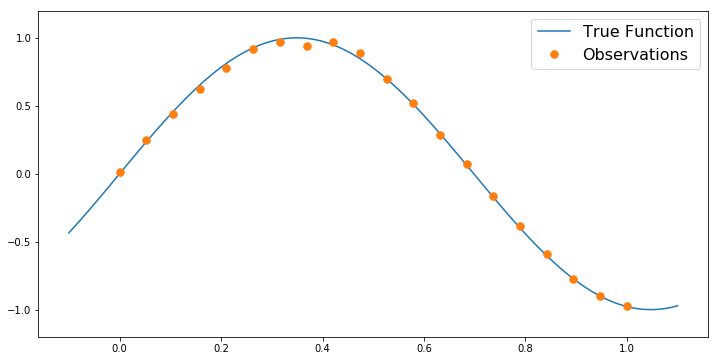

In [4]:
numPlot = 100

plotx = np.linspace(-0.1, 1.1, numPlot)

plt.figure(figsize=(12,6))
plt.plot(plotx, TrueFunc(plotx),label='True Function')
plt.plot(obsLocs,obsData,'.', markersize=15, label = 'Observations')

plt.ylim([-1.2,1.2])
plt.legend(fontsize=16)

## Form the prior on the parameters

In [5]:
polyOrder = 4

priorMean = np.zeros(polyOrder+1)
priorCov = (10*10)*np.eye(polyOrder+1)

prior = mm.Gaussian(priorMean, priorCov).AsDensity()

## Form the prior on the hyperparameters

In [6]:
alpha = 1.0
beta = 0.5
noiseVarPrior = mm.InverseGamma(alpha,beta).AsDensity()

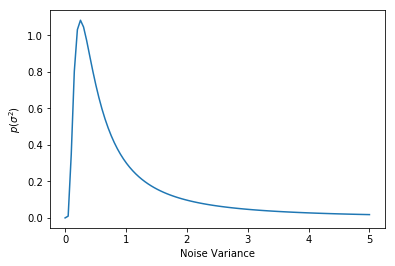

In [7]:
xs = np.linspace(0,5,100)
logpdfs = [noiseVarPrior.LogDensity([[x]]) for x in xs]

plt.plot(xs,np.exp(logpdfs))
plt.xlabel('Noise Variance')
plt.ylabel('$p(\sigma^2)$');

## Form the polynomial model

In [8]:
V = np.ones((numObs,polyOrder+1))
for p in range(1,polyOrder+1): 
    V[:,p] = np.power(obsLocs, p)
    
model = mm.DenseLinearOperator(V)

## Form the Likelihood Function
Construct a Gaussian density with the noise variance as an extra input.  See [here](https://mituq.bitbucket.io/classmuq_1_1Modeling_1_1Gaussian.html) for details.

In [9]:
likelihood = mm.Gaussian(obsData, mm.Gaussian.DiagCovariance).AsDensity()

print('The likelihood has %d inputs with sizes:'%len(likelihood.inputSizes), likelihood.inputSizes)

The likelihood has 2 inputs with sizes: [20 20]


In [10]:
varToVec = mm.DenseLinearOperator(np.ones((numObs,1)))

## Set up the model graph

In [11]:
graph = mm.WorkGraph()

graph.AddNode( mm.IdentityOperator(polyOrder+1), 'Parameters')
graph.AddNode( mm.IdentityOperator(1), 'Noise Variance')

graph.AddNode(mm.DensityProduct(3), 'Posterior')

graph.AddNode(prior, 'Parameter Prior')
graph.AddNode(noiseVarPrior,'VariancePrior')
graph.AddNode(model,'Forward Model')
graph.AddNode(likelihood,'Likelihood')
graph.AddNode(varToVec, 'Variance Tile')

graph.AddEdge('Parameters', 0, 'Parameter Prior', 0)
graph.AddEdge('Parameters', 0, 'Forward Model', 0)
graph.AddEdge('Forward Model', 0, 'Likelihood', 0)

graph.AddEdge('Noise Variance', 0, 'VariancePrior', 0)
graph.AddEdge('Noise Variance', 0, 'Variance Tile', 0)
graph.AddEdge('Variance Tile', 0, 'Likelihood', 1)

graph.AddEdge('Parameter Prior', 0, 'Posterior', 0)
graph.AddEdge('VariancePrior', 0, 'Posterior', 1)
graph.AddEdge('Likelihood', 0, 'Posterior', 2)

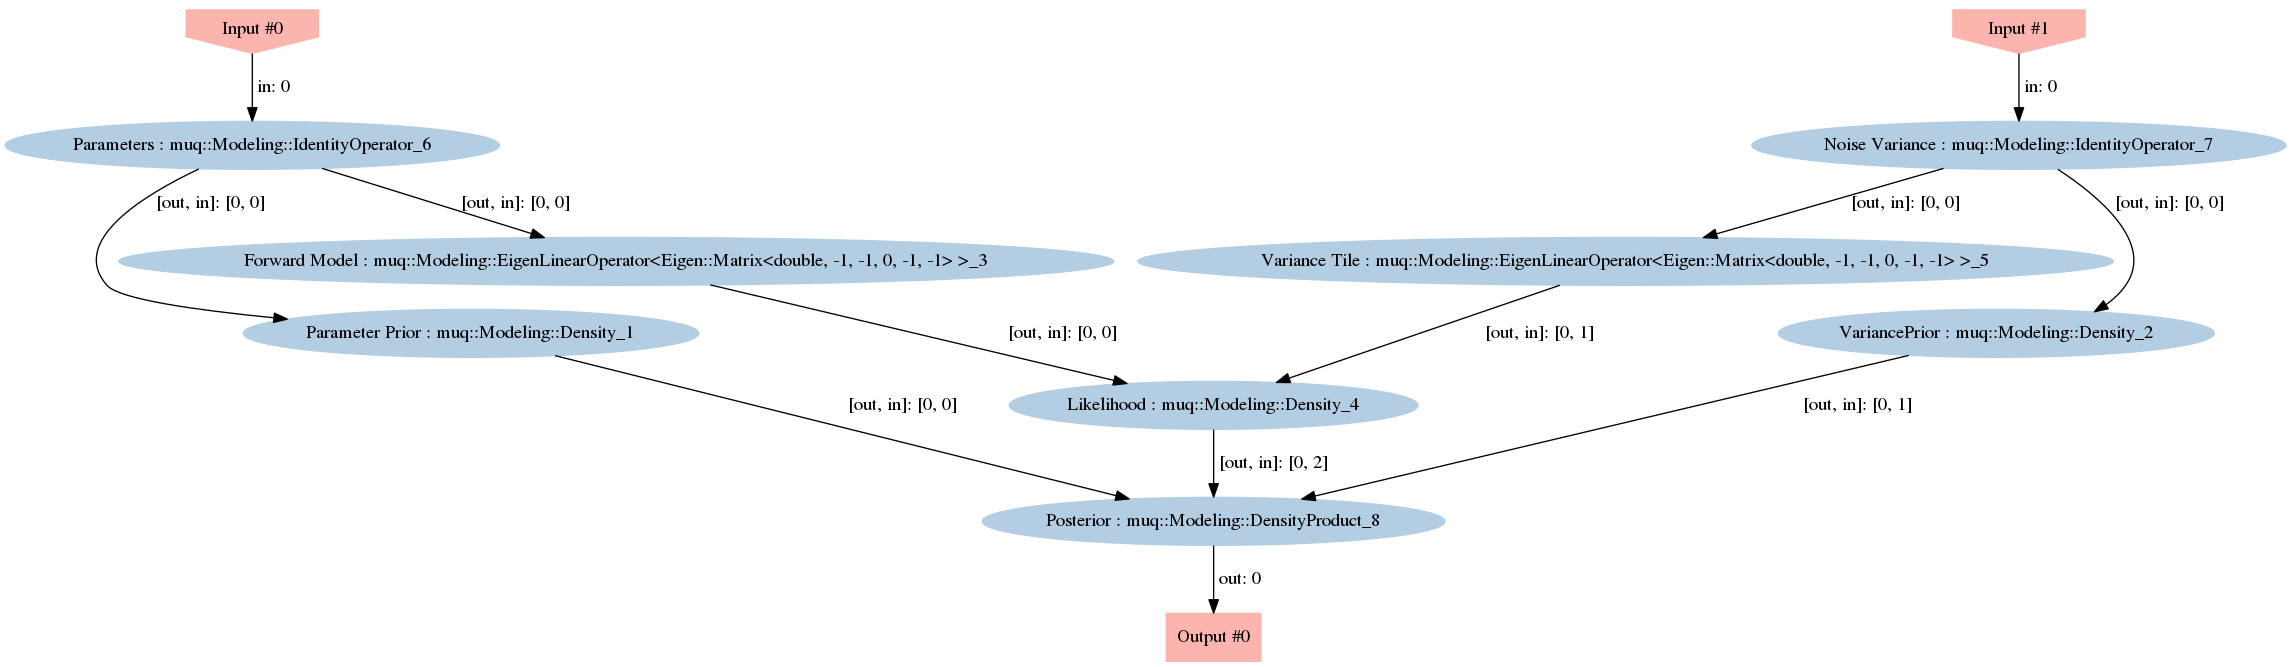

In [12]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png')

## Posterior Sampling

In [13]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [14]:
paramProposal = dict()
paramProposal['Method'] = 'AMProposal'
paramProposal['ProposalVariance'] = 5e-2
paramProposal['AdaptSteps'] = 100
paramProposal['AdaptStart'] = 1000
paramProposal['AdaptScale'] = 0.3

paramOptions = dict()
paramOptions['Method'] = 'MHKernel'
paramOptions['Proposal'] = 'ProposalBlock'
paramOptions['ProposalBlock'] = paramProposal


varProposal = dict()
varProposal['Method'] = 'AMProposal'
varProposal['ProposalVariance'] = 1.0
varProposal['AdaptSteps'] = 100
varProposal['AdaptStart'] = 1000
varProposal['AdaptScale'] = 0.7

varOptions = dict()
varOptions['Method'] = 'MHKernel'
varOptions['Proposal'] = 'ProposalBlock'
varOptions['ProposalBlock'] = varProposal

options = dict()
options['NumSamples'] = 100000
options['ThinIncrement'] = 1
options['BurnIn'] = 20000
options['KernelList'] = 'Parameter Kernel,Variance Kernel'
options['PrintLevel'] = 3
options['Parameter Kernel'] = paramOptions
options['Variance Kernel'] = varOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [15]:
startParams = 0.1*np.ones(polyOrder+1)
startVar = 0.1*np.ones(1)
samps = mcmc.Run([startParams, startVar])

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 19%
    Block 1:
      Acceptance Rate = 14%
  20% Complete
    Block 0:
      Acceptance Rate = 16%
    Block 1:
      Acceptance Rate = 15%
  30% Complete
    Block 0:
      Acceptance Rate = 15%
    Block 1:
      Acceptance Rate = 15%
  40% Complete
    Block 0:
      Acceptance Rate = 15%
    Block 1:
      Acceptance Rate = 15%
  50% Complete
    Block 0:
      Acceptance Rate = 15%
    Block 1:
      Acceptance Rate = 16%
  60% Complete
    Block 0:
      Acceptance Rate = 15%
    Block 1:
      Acceptance Rate = 16%
  70% Complete
    Block 0:
      Acceptance Rate = 15%
    Block 1:
      Acceptance Rate = 17%
  80% Complete
    Block 0:
      Acceptance Rate = 14%
    Block 1:
      Acceptance Rate = 17%
  90% Complete
    Block 0:
      Acceptance Rate = 14%
    Block 1:
      Acceptance Rate = 18%
  100% Complete
    Block 0:
      Acceptance Rate = 14%
    Block 1:
      Acceptance Ra

## Plot the posterior distribution

In [16]:
sampMat = samps.AsMatrix()

Text(0.5,0,'MCMC Step')

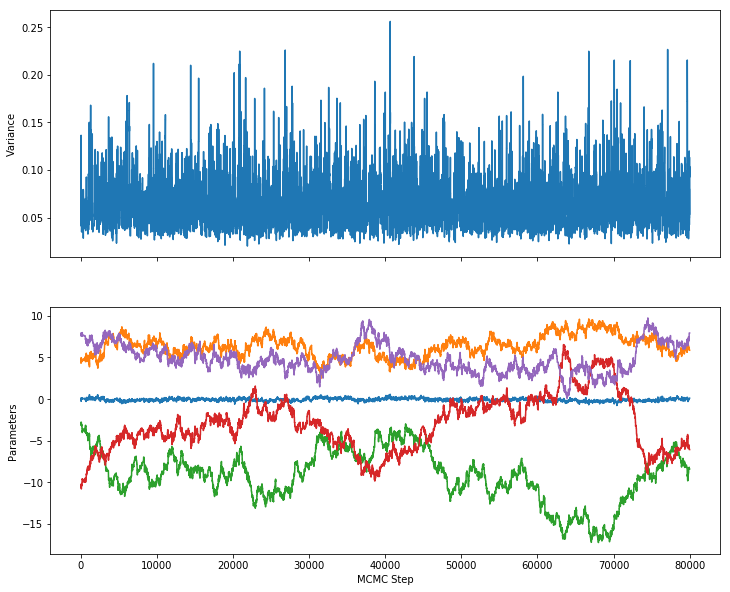

In [17]:
fig,axs = plt.subplots(nrows=2,figsize=(12,10),sharex=True)
axs[0].plot(sampMat[-1,:])
axs[0].set_ylabel('Variance')

axs[1].plot(sampMat[0:-1,:].T)
axs[1].set_ylabel('Parameters')
axs[1].set_xlabel('MCMC Step')

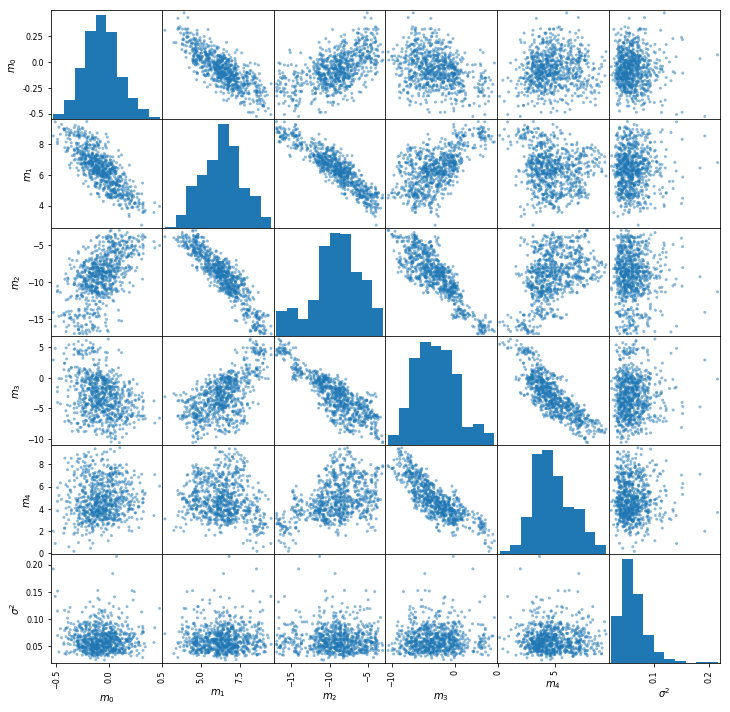

In [18]:
df = pd.DataFrame(sampMat[:,::100].T, columns=(['$m_%d$'%i for i in range(polyOrder+1)] + ['$\sigma^2$']))
scatter_matrix(df,figsize=(12,12));

## Plot the posterior predictive distribution

In [19]:
numPlot = 100
thinBy = 1000

plotx = np.linspace(-0.1, 1.1, numPlot)

predV = np.ones((numPlot,polyOrder+1))
for p in range(1,polyOrder+1): 
    predV[:,p] = np.power(plotx, p)

predSampsNoiseless = predV @ sampMat[0:polyOrder+1]
noiseVarSamps = sampMat[-1,:]
print(noiseVarSamps.shape)

predSampsNoisy = predSampsNoiseless + np.random.randn(numPlot,noiseVarSamps.shape[0]) * np.sqrt(noiseVarSamps)

# Compute the mean, standard deviation, and quantiles of the posterior predictions
predMuNoiseless = np.mean(predSampsNoiseless,axis=1)
predStdNoiseless = np.std(predSampsNoiseless, axis=1)
predQ05Noiseless = np.percentile(predSampsNoiseless,5,axis=1)
predQ95Noiseless = np.percentile(predSampsNoiseless,95,axis=1)

predMuNoisy = np.mean(predSampsNoisy,axis=1)
predStdNoisy = np.std(predSampsNoisy, axis=1)
predQ05Noisy = np.percentile(predSampsNoisy,5,axis=1)
predQ95Noisy = np.percentile(predSampsNoisy,95,axis=1)

(80001,)


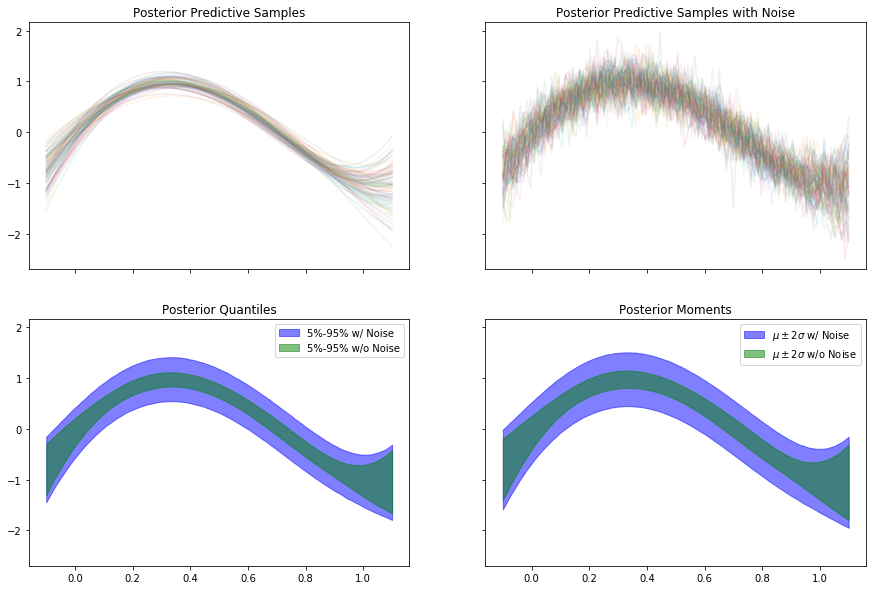

In [20]:
fig,axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(15,10))

axs[0,0].plot(plotx, predSampsNoiseless[:,::thinBy],alpha=0.1);
axs[0,0].set_title('Posterior Predictive Samples')

axs[0,1].plot(plotx, predSampsNoisy[:,::thinBy],alpha=0.1);
axs[0,1].set_title('Posterior Predictive Samples with Noise')


axs[1,0].fill_between(plotx,predQ05Noisy, predQ95Noisy,color='blue',alpha=0.5, label='5%-95% w/ Noise')
axs[1,0].fill_between(plotx,predQ05Noiseless, predQ95Noiseless,color='green',alpha=0.5, label='5%-95% w/o Noise')
axs[1,0].set_title('Posterior Quantiles');
axs[1,0].legend()

axs[1,1].fill_between(plotx, predMuNoisy + 2.0*predStdNoisy, predMuNoisy-2.0*predStdNoisy, color='blue', label='$\mu\pm2\sigma$ w/ Noise', alpha=0.5)
axs[1,1].fill_between(plotx, predMuNoiseless + 2.0*predStdNoiseless, predMuNoiseless-2.0*predStdNoiseless, color='green', label='$\mu\pm2\sigma$ w/o Noise', alpha=0.5)
axs[1,1].set_title('Posterior Moments');
axs[1,1].legend();